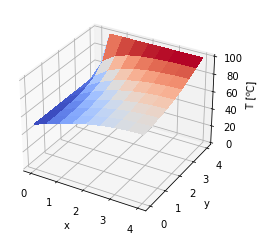

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import scipy 
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pylab as plt
import time
from math import sinh


def setup_LaplaceNeumann_xy(Ttop, Tleft, nx, ny):
    
    n = (nx)*(ny) #number of unknowns
    d = np.ones(n) # diagonals
    b = np.zeros(n) #RHS
    
    d0 = d.copy()*-4
    d1_lower = d.copy()[0:-1]
    
    d1_upper = d1_lower.copy()
    
    dnx_lower = d.copy()[0:-nx]
    
    dnx_upper = dnx_lower.copy()
    
    d1_lower[nx-1::nx] = 0 # every nx element on first diagonal is zero; starting from the nx-th element
    d1_upper[nx-1::nx] = 0
    
    d1_lower[nx-2::nx] = 2 # every nx element on first upper diagonal is two; stating from the first element. 
                 # this correspond to all equations on border (x=0, y)
    
    dnx_upper[0:nx] = 2 # the first nx elements in the nx-th upper diagonal is two; 
                        # This correspond to all equations on border (x, y=0) 
    
    b[-nx:] = -Ttop
    b[0::nx] += -Tleft

    A = scipy.sparse.diags([d0, d1_upper, d1_lower, dnx_upper, dnx_lower], [0, 1, -1, nx, -nx], format='csc').toarray()
    
    return A, b





def plotSurfaceNeumannDirichlet(Temp, Ttop, Tleft, l, N, nxTicks=4, nyTicks=4):
    x = np.linspace(0, l, N + 1)
    y = np.linspace(0, l, N + 1)
    X, Y = np.meshgrid(x, y)
    T = np.zeros_like(X)
    
    T[-1,:] = Ttop
    T[:,0] = Tleft
    #T[-1,:] = Ttop
    k = 1
    #print(T)
    for j in range(N):
        T[j,1:] = Temp[N*(k-1):N*k]
        k+=1
        
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    surf = ax.plot_surface(X, Y, T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
    ax.set_zlim(0, Ttop)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("T [$^o$C]")
    xticks=np.linspace(0.0, l, nxTicks+1)
    ax.set_xticks(xticks)
    yticks=np.linspace(0.0, l, nyTicks+1)
    ax.set_yticks(yticks)
    plt.show()
    

    
N = 8
Ttop = 100
Tleft = 50
    
A, x = setup_LaplaceNeumann_xy(Ttop, Tleft, N, N)

Temps = scipy.linalg.solve(A,x)
    

plotSurfaceNeumannDirichlet(Temps, Ttop, Tleft, 4, N, nxTicks=4, nyTicks=4)




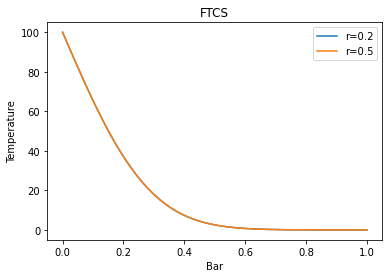

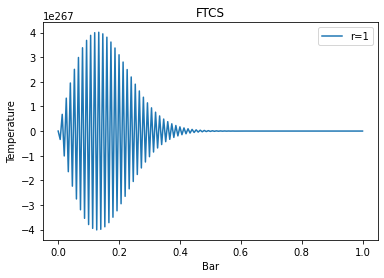

In [2]:
#Problem 2

import numpy as np
import matplotlib.pyplot as plt
from math import exp, sin, pi


def solveNextTimestepFTCS(Uold, D):
    Unew = np.zeros(len(Uold))
    Unew[0] = Uold[0] #Left boundary
    Unew[1:-1] = Uold[1:-1] + D*(Uold[:-2] - 2*Uold[1:-1] + Uold[2:])
    
    return Unew



def plotCouette(): 
    r1, r2, r3 = 0.2, 0.5, 1.0
    N = 150 
    y = np.linspace(0, 1, N + 1)
    h = y[1] - y[0]
    dt1, dt2, dt3 = r1 * h**2, r2 * h**2, r3 * h**2
    
    T = 0.025 # simulation time
    
    time1 = np.arange(0, T + dt1, dt1)
    time2 = np.arange(0, T + dt2, dt2)
    time3 = np.arange(0, T + dt3, dt3)
    
    # Spatial BC
    U_left = 100.0
    U_right = 0.0 

    # solution matrices:
    Unew_1 = np.zeros_like(y)
    Unew_2 = np.zeros_like(y)
    Unew_3 = np.zeros_like(y)
    
    Unew_1[0],Unew_2[0],Unew_3[0] = 100,100,100
 
    #Solution loops
    for i in range(len(time1)):
        Unew_1 = solveNextTimestepFTCS(Unew_1,0.2)
    for i in range(len(time2)):
        Unew_2 = solveNextTimestepFTCS(Unew_2,0.5)
    for i in range(len(time3)):
        Unew_3 = solveNextTimestepFTCS(Unew_3,1)
    
    
    #plots
    plt.plot(y, Unew_1, label="r=0.2")
    plt.plot(y, Unew_2, label="r=0.5")
    plt.title("FTCS")
    plt.xlabel("Bar")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
    #Weird with r=1, stability problems with r > 0.5
    plt.plot(y, Unew_3, label="r=1")
    plt.title("FTCS")
    plt.xlabel("Bar")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
plotCouette()

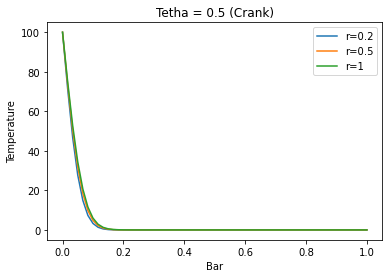

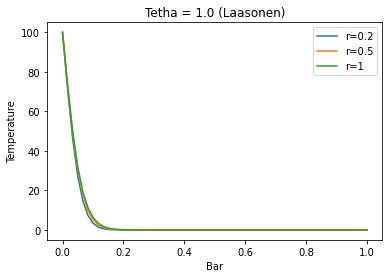

In [3]:
#theta scheme

def thetaScheme_numpy_V2(theta, D, N, wOld):
    wNew = np.zeros_like(wOld)
    superDiag = np.ones(N - 2) * -D * theta
    subDiag = np.ones(N - 2) * -D * theta
    mainDiag = np.ones(N - 1) * (1 + 2*D*theta)
    
    tmp = D*(1. - theta)
    
    a = tmp*wOld[0:-2]
    b = (1 - 2*tmp)*wOld[1:-1]
    c = tmp*wOld[2:]
    
    RHS = a + b + c
    RHS[0] += wOld[0]*D*theta 
    RHS[-1] += wOld[-1]*D*theta
    
    A = scipy.sparse.diags([subDiag, mainDiag, superDiag], [-1, 0, 1], format='csc')
    
    wNew[1:-1] = scipy.sparse.linalg.spsolve(A, RHS)
    wNew[0] = 100
    wNew[-1] = 0
    
    return wNew


def tethaPlot():
    r1, r2, r3 = 0.2, 0.5, 1.0
    N = 60 
    y = np.linspace(0, 1, N+1)
    h = y[1] - y[0]
    dt1, dt2, dt3 = r1 * h**2, r2 * h**2, r3 * h**2
    
    T = 0.001 # simulation time, change it for different times
    
    #Time lists, changing with the different rs
    time1 = np.arange(0, T + dt1, dt1)
    time2 = np.arange(0, T + dt2, dt2)
    time3 = np.arange(0, T + dt3, dt3)
    U_left = 100
    
    
    #Initializing lists and setting boundaries
    Utetha1, UtethaOne1 = np.zeros_like(y),np.zeros_like(y)
    Utetha2, UtethaOne2 = np.zeros_like(y),np.zeros_like(y)
    Utetha3, UtethaOne3 = np.zeros_like(y),np.zeros_like(y)
    Utetha1[0],Utetha2[0],Utetha3[0] = U_left,U_left,U_left
    UtethaOne1[0],UtethaOne2[0],UtethaOne3[0] = U_left,U_left,U_left

    
    #For loops to iterate through the different rs and thetas
    for i in range(len(time1)):
        Utetha1 = thetaScheme_numpy_V2(0.5, 0.2, N, Utetha1)
        UtethaOne1 = thetaScheme_numpy_V2(1, 0.2, N, UtethaOne1)
        
        
    for i in range(len(time2)):
        Utetha2 = thetaScheme_numpy_V2(0.5, 0.5, N, Utetha2)
        UtethaOne2 = thetaScheme_numpy_V2(1, 0.5, N, UtethaOne2)
       
    for i in range(len(time3)):
        Utetha3 = thetaScheme_numpy_V2(0.5, 1, N, Utetha3)
        UtethaOne3 = thetaScheme_numpy_V2(1, 1, N, UtethaOne3)
       
    
    #Plotting for theta = 0.5
    plt.plot(y, Utetha1, label="r=0.2")
    plt.plot(y, Utetha2, label="r=0.5")
    plt.plot(y, Utetha3, label="r=1")
    plt.title("Tetha = 0.5 (Crank)")
    plt.xlabel("Bar")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
    #Plotting for theta = 1.0
    plt.plot(y, UtethaOne1, label="r=0.2")
    plt.plot(y, UtethaOne2, label="r=0.5")
    plt.plot(y, UtethaOne3, label="r=1")
    plt.title("Tetha = 1.0 (Laasonen)")
    plt.xlabel("Bar")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
tethaPlot()

In [4]:
#Problem 3

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import interpolate


#pasting in given function first: 
def animateHyperbolicSolution1D(solvers, u_n_sol_list, u_a_sol, x):
    import matplotlib.pyplot as plt
    from matplotlib import animation
            
    # Set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(min(x),max(x)), ylim=(np.min(u_a_sol), np.max(u_a_sol)*1.1))

    lines=[]     # list for plot lines for solvers and analytical solutions
    legends=[]   # list for legends for solvers and analytical solutions

    for solver in solvers:
        line, = ax.plot([], [], '-', lw=2)
        lines.append(line)
        legends.append(solver.__name__)

    line, = ax.plot([], [], 'k--', lw=2) #add extra plot line for analytical solution
    lines.append(line)
    legends.append('Analytical (linear advection eq.)')

    plt.xlabel('x-coordinate [-]')
    plt.ylabel('Amplitude [-]')
    plt.legend(legends, loc=3, frameon=False)
        
    # initialization function: plot the background of each frame
    def init():
        for line in lines:
            line.set_data([], [])
        return lines,
    # animation function.  This is called sequentially
    def animate(i):
        for k, line in enumerate(lines):
            if (k==len(solvers)):
                line.set_data(x, u_a_sol[i,:])
            else:
                line.set_data(x, u_n_sol_list[k][i,:])
                
        return lines,
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=30, interval=30, blit=False)
    plt.close()
    return anim




#Problem 3 a)

c, a0 = 1, 1 #Courant and a0
x = np.linspace(0,1,100+1)
dx = float((1-0)/100) 
#from CFL condition, we can find dt
dt = (c/a0)*dx
time = np.linspace(0.0,0.8, int((0.8-0.0)/dt)) #time-list from 0 to 0.8

def g(x):
    u0 = np.zeros_like(x)
    x_left = 0.0
    x_right = 0.2
    u0 = np.where((x>x_left) & (x<x_right), np.sin(np.pi*(x-x_left)/(x_right-x_left))**2.0,u0) 
    return u0

def FTBS(Uold):
    #Function to return the next timestep in FTBS scheme
    Unew = np.zeros_like(Uold[1:-1])
    Unew[:] = Uold[1:-1] - a0*(dt/dx)*(Uold[1:-1] - Uold[0:-2])
    return Unew

u0 = g(x) #u0, sinus^2 function
u_num = np.zeros((len(time),len(x))) #numerical
u_num[0,:] = u0

u_ana = np.zeros((len(time), len(x))) #analytical
u_ana[0,:] = u0

u_solve = np.zeros_like(u0)
u_solve[:] = u0[:]
for i, t in enumerate(time[1:]):
    u_ana[i+1,:] = g(x-a0*t)
    u_bound = interpolate.interp1d(x[-2:],u_solve[-2:])
    u_solve[1:-1] = FTBS(u_solve[:])
    u_solve[-1] = u_bound(x[-1]-a0*dt)
    
    u_num[i+1,:] = u_solve[:]
    

from matplotlib import rc
rc('animation', html='html5')
from IPython.display import HTML
animasjon = animateHyperbolicSolution1D([FTBS], [u_num], u_ana, x)
HTML(animasjon.to_jshtml())

In [7]:
# Mac Cormack
macU0 = g(x)
u_num_mac = np.zeros((len(time), len(x)))
u_num_mac[0,:] = macU0
u_ana_mac = np.zeros((len(time), len(x)))
u_ana_mac[0,:] = macU0
#Basically same procedure as FTBS above

def MacCormackScheme(Uold):
    Unew = np.zeros_like(Uold[1:-1])
    Uupper = np.zeros_like(Uold)
    F1,F2 = a0*Uold[:-1], a0*Uold[1:]
    Uupper[:-1] = Uold[:-1] + (dt/dx)*(F1-F2)
    F3,F4 = a0*Uupper[1:-1], a0*Uupper[:-2]
    
    Unew[:] = (Uupper[1:-1]+Uupper[1:-1])/2 + (dt/dx)*(F3-F4)/2
    
    return Unew


#Pasting the same procedure as the FTBS in task a), giving new names

u_solve_mac = np.zeros_like(macU0)
u_solve_mac[:] = macU0[:]
for i, t in enumerate(time[1:]):
    u_ana_mac[i+1,:] = g(x-a0*t)
    u_bound_mac = interpolate.interp1d(x[-2:],u_solve_mac[-2:])
    u_solve_mac[1:-1] = MacCormackScheme(u_solve_mac[:])
    u_solve_mac[-1] = u_bound_mac(x[-1]-a0*dt)
    
    u_num_mac[i+1,:] = u_solve_mac[:]

    
#Same animation stuff as in a) with maccormack
from matplotlib import rc
rc('animation', html='html5')
from IPython.display import HTML


anim_macCor = animateHyperbolicSolution1D([MacCormackScheme], [u_num_mac], u_ana_mac, x)

HTML(anim_macCor.to_jshtml())  
    

#Animation gets destroyed somehow



In [ ]:
#c) 

a0_adv, c_adv = 1, 0.5

x_adv = np.linspace(0,1,101)
dx_adv = x_adv[1]-x_adv[0]
#Using cfl condition gives:
dt_adv = c_adv*dx_adv / a0_adv

time_adv = np.linspace(0,0.8, int((0.8-0.0)/dt_adv))

def LeapFrog(Uold_1, Uold_2):
    U_leap = Uold_2[1:-1] - c_adv*(Uold_1[2:]-Uold[:-2])
    return U_leap

#Need to use FTBS for 1:-1, but everything else will be pretty
#similar to the problems above

#DOnt know how to do this problem unfortunately. Very hard exercise overall
